# Quantum-Classical Hybrid Neural Network Comparison
This notebook compares different neural network architectures including:
- Classical Multi-Layer Perceptrons (MLP)
- Quantum circuits with LINEAR output mapping
- Quantum circuits with various GROUPING strategies

## 1. Import Librairies
First, we’ll import all necessary libraries for our experiment:
- **PyTorch**: For neural network implementation and training
- **Perceval**: For quantum circuit simulation
- **Matplotlib/Seaborn**: For visualization
- **Custom modules**: For quantum layers and MLP models

In [3]:
!pip install merlinquantum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.5 MB/s eta 0:00:00


In [15]:
from collections import defaultdict

import matplotlib.pyplot as plt
import perceval as pcvl
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib

%matplotlib inline
from merlin.core.layer import QuantumLayer, OutputMappingStrategy
from merlin.datasets.mlp_model import MLP, MLPConfig

from merlin.datasets import iris

## 2. Load and Prepare the Iris Dataset
We’ll use the classic Iris dataset for multi-class classification. This dataset is ideal for comparing different architectures as it provides a simple but non-trivial classification task.

The dataset contains:
- 4 features: sepal length, sepal width, petal length, petal width
- 3 classes: Setosa, Versicolor, Virginica
- 150 samples total (split into train/test sets)

In [16]:
train_features, train_labels, train_metadata = iris.get_data_train()
test_features, test_labels, test_metadata = iris.get_data_test()

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(train_features)
y_train = torch.LongTensor(train_labels)
X_test = torch.FloatTensor(test_features)
y_test = torch.LongTensor(test_labels)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(torch.unique(y_train))}")

Training samples: 120
Test samples: 30
Features: 4
Classes: 3


## 3. Define Model Variants

We’ll test several model architectures to compare classical and quantum approaches:

### Classical Models:

`MLP`: Multi-layer perceptron with 8 hidden units, ReLU activation, and 0.1 dropout

### Quantum Models:

- `LINEAR-7modes-nobunching`: Uses linear output mapping with 7 quantum modes and no-bunching constraint
- `LEXGROUPING-7modes`: Uses lexicographic grouping strategy for output mapping
- `MODGROUPING-7modes`: Uses modular grouping strategy for output mapping

Each model type has a distinct color and line style for visualization.

In [17]:
def get_model_variants():
    """Define different variants for each model type"""
    # Define consistent colors for each model type
    MODEL_COLORS = {
        'MLP': '#1f77b4',  # Blue
        'LINEAR': '#2ca02c',  # Green
        'GROUPING': '#ff7f0e'  # Orange
    }

    # Define line styles for variants
    LINE_STYLES = ['--', '-', ':', '-.']

    variants = {
        'MLP': [
            {
                'name': 'MLP',
                'config': MLPConfig(hidden_sizes=[8], dropout=0.1, activation='relu'),
                'color': MODEL_COLORS['MLP'],
                'linestyle': LINE_STYLES[0]
            }
        ],
        'LINEAR': [
            {
                'name': 'LINEAR-7modes-nobunching',
                'config': {
                    'm': 7,
                    'output_mapping_strategy': OutputMappingStrategy.LINEAR,
                    'no_bunching': True
                },
                'color': MODEL_COLORS['LINEAR'],
                'linestyle': LINE_STYLES[1]
            }
        ],
        'GROUPING': [
            {
                'name': 'LEXGROUPING-7modes',
                'config': {
                    'm': 6,
                    'output_mapping_strategy': OutputMappingStrategy.LEXGROUPING
                },
                'color': MODEL_COLORS['GROUPING'],
                'linestyle': LINE_STYLES[2]
            },
            {
                'name': 'MODGROUPING-7modes',
                'config': {
                    'm': 6,
                    'output_mapping_strategy': OutputMappingStrategy.MODGROUPING
                },
                'color': MODEL_COLORS['GROUPING'],
                'linestyle': LINE_STYLES[1]
            }
        ]
    }
    return variants

## 4. Quantum Circuit Architecture

The quantum circuit is composed of three main sections:

1. **Left interferometer (WL)**: Performs initial quantum state transformation using beam splitters and phase shifters

2. **Variable phase shifters**: Encodes the 4 input features into quantum phases

3. **Right interferometer (WR)**: Performs final quantum state transformation

The interferometers use a rectangular arrangement of optical elements, where each layer consists of beam splitters (BS) and programmable phase shifters (PS). The phase shifters contain trainable parameters that are optimized during training.

In [18]:
def create_quantum_circuit(m):
    """Create quantum circuit with specified number of modes

    Parameters:
    -----------
    m : int
        Number of quantum modes in the circuit

    Returns:
    --------
    pcvl.Circuit
        Complete quantum circuit with trainable parameters
    """
    # Left interferometer with trainable parameters
    wl = pcvl.GenericInterferometer(m,
                                    lambda i: pcvl.BS() // pcvl.PS(pcvl.P(f"theta_li{i}")) // \
                                              pcvl.BS() // pcvl.PS(pcvl.P(f"theta_lo{i}")),
                                    shape=pcvl.InterferometerShape.RECTANGLE)

    # Variable phase shifters for input encoding
    c_var = pcvl.Circuit(m)
    for i in range(4):  # 4 input features
        px = pcvl.P(f"px{i + 1}")
        c_var.add(i + (m - 4) // 2, pcvl.PS(px))

    # Right interferometer with trainable parameters
    wr = pcvl.GenericInterferometer(m,
                                    lambda i: pcvl.BS() // pcvl.PS(pcvl.P(f"theta_ri{i}")) // \
                                              pcvl.BS() // pcvl.PS(pcvl.P(f"theta_ro{i}")),
                                    shape=pcvl.InterferometerShape.RECTANGLE)

    # Combine all components
    c = pcvl.Circuit(m)
    c.add(0, wl, merge=True)
    c.add(0, c_var, merge=True)
    c.add(0, wr, merge=True)

    return c

## 5. Model Factory Functions

These utility functions handle model creation and parameter counting. The `create_model` function serves as a factory that instantiates either classical MLP models or quantum models based on the specified configuration.

In [19]:
def create_model(model_type, variant):
    """Create model instance based on type and variant

    Parameters:
    -----------
    model_type : str
        Type of model ('MLP' or quantum model types)
    variant : dict
        Configuration dictionary for the model variant

    Returns:
    --------
    nn.Module
        PyTorch model instance
    """
    if model_type == 'MLP':
        return MLP(input_size=4, output_size=3, config=variant['config'])
    else:
        m = variant['config']['m']
        no_bunching = variant['config'].get('no_bunching', False)
        c = create_quantum_circuit(m)
        return QuantumLayer(
            input_size=4, output_size=3,
            circuit=c,
            trainable_parameters=["theta"],
            input_parameters=["px"],
            input_state=[1, 0] * (m // 2) + [0] * (m % 2),
            no_bunching=no_bunching,
            output_mapping_strategy=variant['config']['output_mapping_strategy']
        )

def count_parameters(model):
    """Count trainable parameters in a PyTorch model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 6. Training Function

The training function implements a standard supervised learning loop with the following characteristics:
- **Optimizer**: Adam with learning rate 0.02
- **Loss function**: Cross-entropy for multi-class classification
- **Batch size**: 32 samples
- **Epochs**: 50 (default)

The function tracks training loss, training accuracy, and test accuracy at each epoch. After training completes, it generates a detailed classification report.

In [20]:
def train_model(model, X_train, y_train, X_test, y_test, model_name, n_epochs=50, batch_size=32, lr=0.02):
    """Train a model and track metrics

    Parameters:
    -----------
    model : nn.Module
        Model to train
    X_train, y_train : torch.Tensor
        Training data and labels
    X_test, y_test : torch.Tensor
        Test data and labels
    model_name : str
        Name for progress bar display
    n_epochs : int
        Number of training epochs
    batch_size : int
        Batch size for mini-batch training
    lr : float
        Learning rate

    Returns:
    --------
    dict
        Training results including losses, accuracies, and final report
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()

    pbar = tqdm(range(n_epochs), leave=False, desc=f"Training {model_name}")
    for epoch in pbar:
        # Shuffle training data
        permutation = torch.randperm(X_train.size()[0])
        total_loss = 0

        # Mini-batch training
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (X_train.size()[0] // batch_size)
        losses.append(avg_loss)
        pbar.set_description(f"Training {model_name} - Loss: {avg_loss:.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            # Training accuracy
            train_outputs = model(X_train)
            train_preds = torch.argmax(train_outputs, dim=1).numpy()
            train_acc = accuracy_score(y_train.numpy(), train_preds)
            train_accuracies.append(train_acc)

            # Test accuracy
            test_outputs = model(X_test)
            test_preds = torch.argmax(test_outputs, dim=1).numpy()
            test_acc = accuracy_score(y_test.numpy(), test_preds)
            test_accuracies.append(test_acc)

        model.train()

    # Generate final classification report
    model.eval()
    with torch.no_grad():
        final_test_outputs = model(X_test)
        final_test_preds = torch.argmax(final_test_outputs, dim=1).numpy()
        final_report = classification_report(y_test.numpy(), final_test_preds)

    return {
        'losses': losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_test_acc': test_accuracies[-1],
        'classification_report': final_report
    }

## 7. Multi-Run Training Function

To ensure robust and statistically meaningful results, we train each model variant multiple times with different random initializations. This approach helps us:
- Understand the variance in model performance
- Identify which architectures are more stable
- Avoid drawing conclusions from lucky/unlucky single runs
- Calculate confidence intervals for performance metrics

The function tracks both individual run results and aggregate statistics across all runs.

In [21]:
def train_all_variants(X_train, y_train, X_test, y_test, num_runs=5):
    """Train all model variants multiple times and return results

    Parameters:
    -----------
    X_train, y_train : torch.Tensor
        Training data and labels
    X_test, y_test : torch.Tensor
        Test data and labels
    num_runs : int
        Number of independent training runs per variant

    Returns:
    --------
    tuple
        (all_results, best_models) - Complete results and best performing models
    """
    variants = get_model_variants()
    all_results = defaultdict(dict)
    best_models = {}

    for model_type, model_variants in variants.items():
        print(f"\n\nTraining {model_type} variants:")
        best_acc = 0

        for variant in model_variants:
            print(f"\nTraining {variant['name']}... ({count_parameters(create_model(model_type, variant))} parameters)")

            # Store results from multiple runs
            variant_runs = []

            for run in range(num_runs):
                model = create_model(model_type, variant)
                print(f"  Run {run + 1}/{num_runs}...")

                results = train_model(model, X_train, y_train, X_test, y_test, f"{variant['name']}-run{run + 1}")
                results['model'] = model
                results['color'] = variant['color']
                results['linestyle'] = variant['linestyle']
                variant_runs.append(results)

                # Track best model for each type
                if results['final_test_acc'] > best_acc:
                    best_acc = results['final_test_acc']
                    best_models[model_type] = {
                        'name': variant['name'],
                        'model': model,
                        'results': results
                    }

            # Store all runs for this variant
            all_results[model_type][variant['name']] = {
                'runs': variant_runs,
                'color': variant['color'],
                'linestyle': variant['linestyle'],
                'avg_final_test_acc': sum(run['final_test_acc'] for run in variant_runs) / num_runs
            }

    return all_results, best_models

## 8. Visualization Functions

### Training Curves Visualization

This function creates a comprehensive view of the training process by plotting three key metrics:
1. **Training Loss**: Shows how well the model fits the training data
2. **Training Accuracy**: Indicates the model’s performance on training samples
3. **Test Accuracy**: Reveals the model’s generalization capability

For each model variant, we display:
- **Solid line**: Mean performance across all runs
- **Shaded area**: Performance envelope (min to max values)

This visualization helps identify overfitting, convergence speed, and stability.

In [22]:
def plot_training_curves(all_results):
    """Plot training curves for all model variants with average and envelope

    Shows three subplots:
    1. Training loss over epochs
    2. Training accuracy over epochs
    3. Test accuracy over epochs

    Each line represents the mean across runs, with shaded areas showing min/max envelope.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Plot each metric
    for model_type, variants in all_results.items():
        for variant_name, variant_data in variants.items():
            color = variant_data['color']
            linestyle = variant_data['linestyle']
            label = f"{variant_name}"

            # Get data from all runs
            losses_runs = [run['losses'] for run in variant_data['runs']]
            train_acc_runs = [run['train_accuracies'] for run in variant_data['runs']]
            test_acc_runs = [run['test_accuracies'] for run in variant_data['runs']]

            # Calculate mean values across all runs
            epochs = len(losses_runs[0])
            mean_losses = [sum(run[i] for run in losses_runs) / len(losses_runs) for i in range(epochs)]
            mean_train_acc = [sum(run[i] for run in train_acc_runs) / len(train_acc_runs) for i in range(epochs)]
            mean_test_acc = [sum(run[i] for run in test_acc_runs) / len(test_acc_runs) for i in range(epochs)]

            # Calculate min and max values for the envelope
            min_losses = [min(run[i] for run in losses_runs) for i in range(epochs)]
            max_losses = [max(run[i] for run in losses_runs) for i in range(epochs)]

            min_train_acc = [min(run[i] for run in train_acc_runs) for i in range(epochs)]
            max_train_acc = [max(run[i] for run in train_acc_runs) for i in range(epochs)]

            min_test_acc = [min(run[i] for run in test_acc_runs) for i in range(epochs)]
            max_test_acc = [max(run[i] for run in test_acc_runs) for i in range(epochs)]

            # Plot mean lines
            ax1.plot(mean_losses, label=label, color=color, linestyle=linestyle, linewidth=2)
            ax2.plot(mean_train_acc, label=label, color=color, linestyle=linestyle, linewidth=2)
            ax3.plot(mean_test_acc, label=label, color=color, linestyle=linestyle, linewidth=2)

            # Plot envelopes (filled area between min and max)
            epochs_range = range(epochs)
            ax1.fill_between(epochs_range, min_losses, max_losses, color=color, alpha=0.2)
            ax2.fill_between(epochs_range, min_train_acc, max_train_acc, color=color, alpha=0.2)
            ax3.fill_between(epochs_range, min_test_acc, max_test_acc, color=color, alpha=0.2)

    # Customize plots
    for ax, title in zip([ax1, ax2, ax3], ['Training Loss', 'Training Accuracy', 'Test Accuracy']):
        ax.set_title(title, fontsize=12, pad=10)
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel(title.split()[-1], fontsize=10)
        ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

### Confusion Matrix Visualization

Confusion matrices provide detailed insights into classification performance by showing:
- Which classes are correctly classified (diagonal elements)
- Which classes are confused with each other (off-diagonal elements)
- Overall performance patterns for each model architecture

We display the confusion matrix for the best-performing model of each type.

In [23]:
def plot_best_confusion_matrices(best_models, X_test, y_test):
    """Plot confusion matrices for the best model of each type"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    class_names = ['setosa', 'versicolor', 'virginica']

    for idx, (model_type, best) in enumerate(best_models.items()):
        model = best['model']
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            predictions = torch.argmax(outputs, dim=1).numpy()

        cm = confusion_matrix(y_test.numpy(), predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
        axes[idx].set_title(f'Best {model_type}\n({best["name"]})')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
        plt.setp(axes[idx].get_xticklabels(), rotation=45)
        plt.setp(axes[idx].get_yticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

## 9. Results Summary Function

This function provides a comprehensive statistical analysis of the experimental results, including:
- **Parameter efficiency**: Number of trainable parameters for each model
- **Performance statistics**: Mean accuracy, standard deviation, min/max values
- **Detailed classification reports**: Precision, recall, and F1-score for each class

These metrics help in making informed decisions about model selection based on the specific requirements of your application.

In [24]:
def print_comparison_results(all_results, best_models):
    """Print detailed comparison of all models and variants with multi-run statistics"""
    print("\n----- Model Comparison Results -----")

    # Print results for all variants
    print("\nAll Model Variants Results (averaged over multiple runs):")
    for model_type, variants in all_results.items():
        print(f"\n{model_type} Variants:")
        for variant_name, variant_data in variants.items():
            print(f"\n{variant_name}:")
            print(f"Parameters: {count_parameters(variant_data['runs'][0]['model'])}")

            # Calculate statistics across runs
            final_accs = [run['final_test_acc'] for run in variant_data['runs']]
            avg_acc = sum(final_accs) / len(final_accs)
            min_acc = min(final_accs)
            max_acc = max(final_accs)
            std_acc = (sum((acc - avg_acc) ** 2 for acc in final_accs) / len(final_accs)) ** 0.5

            print(f"Final Test Accuracy: {avg_acc:.4f} ± {std_acc:.4f} (min: {min_acc:.4f}, max: {max_acc:.4f})")

    # Print best model results
    print("\nBest Models:")
    for model_type, best in best_models.items():
        print(f"\nBest {model_type} Model: {best['name']}")
        print(f"Final Test Accuracy: {best['results']['final_test_acc']:.4f}")
        print(f"Classification Report:\n{best['results']['classification_report']}")


## 10. Run the Complete Experiment

Now we’ll execute the full experimental pipeline. The experiment consists of:

1. **Multiple training runs**: Each model variant is trained 5 times with different random seeds
2. **Performance tracking**: All metrics are recorded for statistical analysis
3. **Visualization**: Training curves and confusion matrices are generated
4. **Statistical summary**: Detailed performance statistics are computed

This comprehensive approach ensures reliable and reproducible results.

In [25]:
# Set number of independent runs per model variant
num_runs = 5

# Train all variants
print("Starting training process...")
all_results, best_models = train_all_variants(X_train, y_train, X_test, y_test, num_runs=num_runs)

Starting training process...


Training MLP variants:

Training MLP... (67 parameters)
  Run 1/5...


  Run 2/5...


  Run 3/5...


  Run 4/5...


  Run 5/5...




Training LINEAR variants:

Training LINEAR-7modes-nobunching... (192 parameters)
  Run 1/5...


  Run 2/5...


  Run 3/5...


  Run 4/5...


  Run 5/5...




Training GROUPING variants:

Training LEXGROUPING-7modes... (60 parameters)
  Run 1/5...


  Run 2/5...


  Run 3/5...


  Run 4/5...


  Run 5/5...



Training MODGROUPING-7modes... (60 parameters)
  Run 1/5...


  Run 2/5...


  Run 3/5...


  Run 4/5...


  Run 5/5...


### Visualize Training Progress

The following plots show how each model’s performance evolves during training. Pay attention to:
- **Convergence speed**: How quickly each model reaches its best performance
- **Stability**: Width of the shaded area indicates variance across runs
- **Final performance**: Where each model plateaus

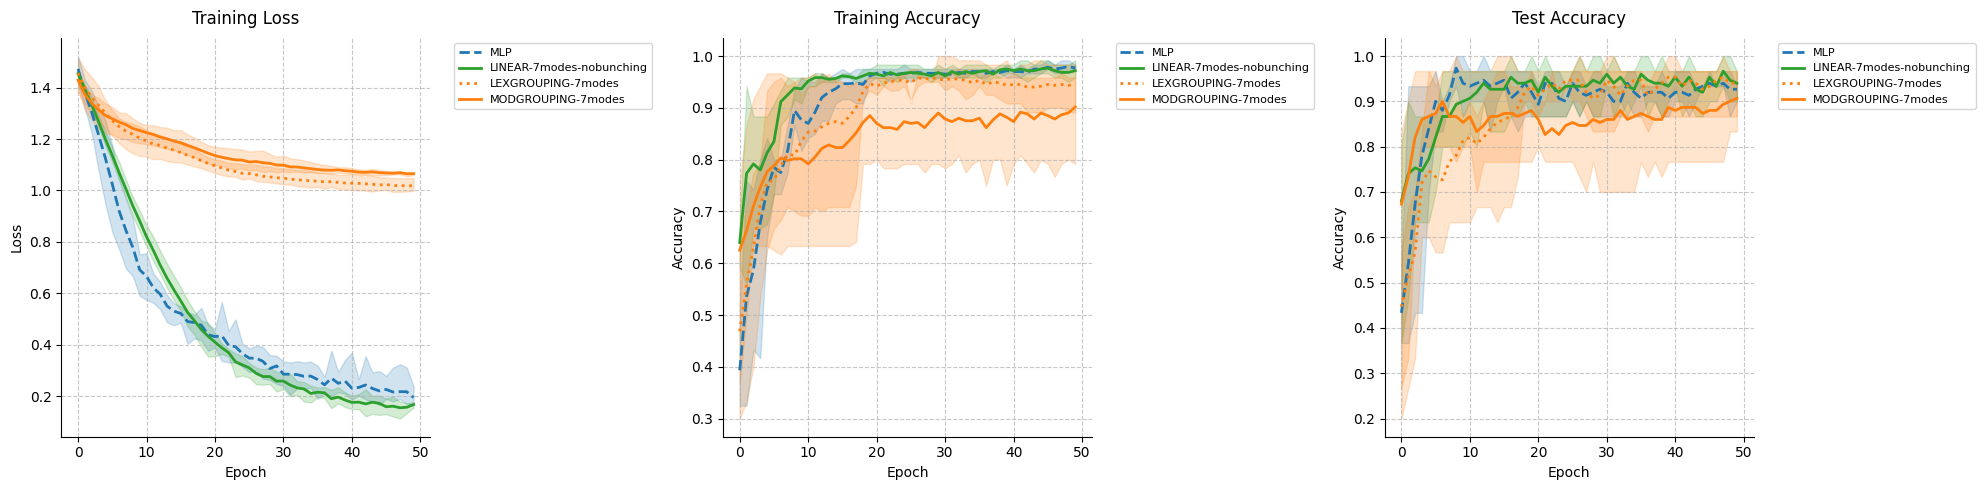

In [27]:
plot_training_curves(all_results)

In [26]:
print_comparison_results(all_results, best_models)


----- Model Comparison Results -----

All Model Variants Results (averaged over multiple runs):

MLP Variants:

MLP:
Parameters: 67
Final Test Accuracy: 0.9267 ± 0.0133 (min: 0.9000, max: 0.9333)

LINEAR Variants:

LINEAR-7modes-nobunching:
Parameters: 192
Final Test Accuracy: 0.9400 ± 0.0327 (min: 0.9000, max: 0.9667)

GROUPING Variants:

LEXGROUPING-7modes:
Parameters: 60
Final Test Accuracy: 0.9400 ± 0.0389 (min: 0.8667, max: 0.9667)

MODGROUPING-7modes:
Parameters: 60
Final Test Accuracy: 0.9067 ± 0.0533 (min: 0.8333, max: 0.9667)

Best Models:

Best MLP Model: MLP
Final Test Accuracy: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.75      1.00      0.86         6
           2       1.00      0.82      0.90        11

    accuracy                           0.93        30
   macro avg       0.92      0.94      0.92        30
weighted avg       0.95      0.93      0.93   

## 11. Key Findings and Conclusions

Based on the experimental results, we can draw several important conclusions:

### Model Complexity vs Performance:
- Compare the number of parameters required by each architecture
- Assess whether quantum models achieve similar performance with fewer parameters

### Training Stability:
- The variance across multiple runs indicates how sensitive each model is to initialization
- Lower variance suggests more reliable training

### Generalization Capability:

- The gap between training and test accuracy reveals overfitting tendencies
- Smaller gaps indicate better generalization

### Classification Patterns:

- Confusion matrices show which flower species are most difficult to distinguish
- This can guide feature engineering or model selection

### Practical Considerations:

For deployment, consider:

- Classical MLPs: Well-understood, fast inference, established deployment pipelines
- Quantum models: Potentially more parameter-efficient, may offer advantages on quantum hardware

### Future Research Directions:

1. Scaling to larger datasets: Test on more complex classification tasks
2. Noise modeling: Investigate performance under realistic quantum noise conditions
3. Hybrid architectures: Combine classical and quantum layers
4. Hardware implementation: Evaluate on actual quantum photonic devices
5. Feature encoding strategies: Explore different ways to encode classical data into quantum states